# Implementation of Models

In this notebook we will implement a bunch of models that will predict if a person has diabetes or not. This said, we will need a lot of libraries!

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Data Processing

Now we will import the typical `diabetes data set`:

In [2]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1


Let us inspect this data set a bit. In particular, let us take a deeper look into the `Pregnancies` variable:

In [3]:
diabetes['Pregnancies'].value_counts()

1     356
0     301
2     284
3     195
4     191
5     141
6     131
7     100
8      96
9      70
10     54
11     24
12     23
13     22
14      7
17      3
15      2
Name: Pregnancies, dtype: int64

So we have three women that have had 17 pregnancies! Is not that a little odd? Let us take a peek into this:

In [4]:
diabetes[diabetes['Pregnancies'] == 17]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
159,17,163,72,41,114,40.9,0.817,47,1
1317,17,163,72,41,114,40.9,0.817,47,1
1980,17,163,72,41,114,40.9,0.817,47,1


These three women are actually the same person! It seems that we have observations that are redundant. To get rid of these duplicates we can use the `drop_duplicates` method:

In [5]:
diabetes = diabetes.drop_duplicates()
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1564,1,100,62,0,0,64.4,0.152,36,0
1565,0,163,40,23,64,40.7,0.322,33,0
1566,6,139,84,37,0,50.7,0.320,50,1
1567,2,167,44,30,140,52.7,0.452,28,0


As we can see we had lots of duplicates. It is kind of inconvenient since this reduced the size of our dataset quite a bit. Anyhoo, life is like that sometimes. 

## Dealing with Missing Data

In a previous episode, we noticed that there are a lot of missing values that were replaced by zeros. In some cases it is convenient to replace those values by an estimation of what should be in their place. There are several options for this, for instance, replacing those `NaNs` with zeros, however, we can better than that: another option is to use **regression** for estimating those values that are not with us anymore. Having this said, how many zeros we have per variable?

In [6]:
diabetes.replace([0], np.nan).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 0 to 1568
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               632 non-null    float64
 1   Glucose                   739 non-null    float64
 2   BloodPressure             710 non-null    float64
 3   SkinThickness             529 non-null    float64
 4   Insulin                   385 non-null    float64
 5   BMI                       734 non-null    float64
 6   DiabetesPedigreeFunction  744 non-null    float64
 7   Age                       744 non-null    int64  
 8   Outcome                   253 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 58.1 KB


As you can see, the variable `Insulin` has a lot of zeros. What variables could be useful for estimating the missing insulin numbers? A correlation matrix can give us some hints.

Text(0.5, 1.0, 'Correlation matrix for the diabetes dataset')

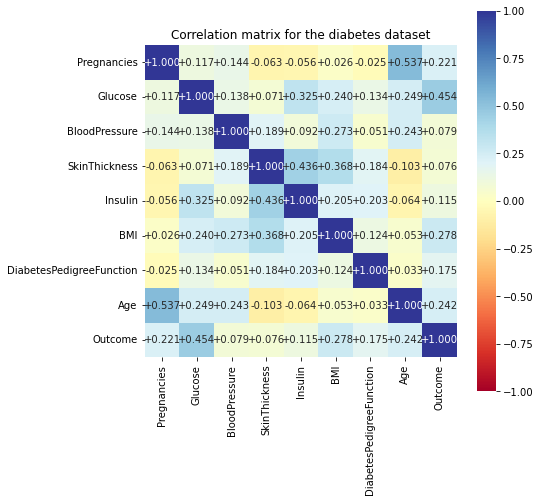

In [7]:
plt.figure(figsize=(7,7))
sns.heatmap(diabetes.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Correlation matrix for the diabetes dataset")

Since several variables have many zeros, we can estimate the missing numbers by employing some model capable of doing regression. In this case, we will use **k-Nearest Neighbors**. Nevertheless, we are not interested in replacing the zeros of either `Pregnancies` and `Outcome`, but for variables such as `Glucose` this could be useful. 

What we will have to do is that for each variable that has zeros, we will use the other variables as predictors, employ only observations that have no missing data, and train a `kNN` model to estimate the missing values. As you can imagine, we will have to repeat this process several times.

In [8]:
no_glucose = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_bloodpressure = ['Glucose', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_skin = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_insulin = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_bmi = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

In [9]:
predictors_set = [no_glucose, no_bloodpressure, no_skin, no_insulin, no_bmi]
objectives = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_hat = diabetes.copy()
k = 5

for predictors, objective in zip(predictors_set, objectives):
    X = diabetes_hat[diabetes_hat[predictors].isin([0]).any(axis=1).apply(lambda x: not x)]
    y = X[objective]
    X = X.drop(columns=objective)
    kNN_model = KNeighborsRegressor(n_neighbors=k).fit(X,y)
    X_hat = diabetes_hat[diabetes_hat[objective] == 0].drop(columns=objective)
    diabetes_hat.loc[diabetes_hat[objective] == 0, objective] = kNN_model.predict(X_hat)

diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,3.752688,120.892473,68.959677,20.908602,79.534946,32.229704,0.472355,33.142473,0.340054
std,3.335541,31.943115,19.317521,16.311726,111.745897,8.206319,0.326181,11.751286,0.474046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.300000,0.375500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,130.000000,36.800000,0.632500,40.250000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


## Training and Testing sets

As usual, we need to create our training and testing datasets. First, we will create a `dataframe` that will contain only the predictors and a `series` for our labels.

In [10]:
X = diabetes_hat
y = X['Outcome']
X = X.drop(columns='Outcome')

For improving the convergence of the models during their training it is recommended to normalize our data so that the magnitudes of all of our variables are roughly the same. This is done in the following cell.

In [11]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

And now we can create our `train set` and the `test set`.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Implementing the Models

Now we implement a bunch of models. We will start with the simple and intuitive model known as **Decision Trees**. This model can do both regression and classification, but we will use them for doing classification.

In [13]:
tree_model = tree.DecisionTreeClassifier().fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

One of the disadvantages of Decission Trees is that tend to overfit the data. One model that overcomes this is the **Random Forest**, which in a few words is a bunch of trees that are built in a random fashion. The predictions done by each of the trees of the random forest are *averaged* to come up with a prediction.

In [14]:
random_model = RandomForestClassifier().fit(X_train,y_train)
y_pred_rand = random_model.predict(X_test)

The `XGB Classifier`, also known as `XGBoost`, is the **Extreme** version of **Gradient Boosting**, or in other words, an implementation of Gradient Boosting. Very briefly, Gradient Boosting is a collection of weak Decision Trees that are aggregated to produce a powerful model. In fact, `XGBoost` dominate in many **Kaggle Competitions**. 

In [15]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error').fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

A classic model in machine learning is **Support Vector Machine**. This model finds the best hyperplanes that create the biggest separation between observations that belong to different categories. Furthermore, it has a trick under its sleeve known as the **kernel trick** that allows us to work with decision boundaries more complex than a hyperplane.

In [16]:
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

Finally, another classic of machine learning is **Logistic Regression**. Despite its name has the word regression in it, this model is used for classification purposes only. In its simple version it is used for binary classification, but it can be extended for multiple classification. It works well if classes are linearly separable. 

In [17]:
logistic_model = LogisticRegression().fit(X_train, y_train)
y_pred_log = logistic_model.predict(X_test)

## Evaluating Classification Models

So we have implemented several models, but which is the winner, or in other words, the best model for our data? To answer this question we need **evaluation metrics**. There are tons of metrics, and the ideal metric, or metrics, will have to be chosen depending on what is important for our particular application. For now, we will mention a few of the most common, however, before going any further, we need to say a few things about the **confusion matrix**.

#### Confusion Matrix

A confusion matrix is a table that allows us to visualize the performance of a classification algorithm. 

<img src="confusion.png" alt="Drawing" style="width: 600px;"/>

This type of table receives this name because it lets us observe whether an algorithm is mislabeling two classes (Image taken from https://en.wikipedia.org/wiki/Precision_and_recall). 

#### Accuracy

Accuracy is defined as follows:

$$
\text{Accuracy}=\frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{false positives} +  \text{true negatives} + \text{false negatives}}.
$$

This metric is useful when both classes are equally important and when we have balanced sets, which is not always the case.

#### Precision

The ratio of positive cases that were correctly labeled over all the examples that were classified as positive is called **precision**:

$$
\text{Precision}=\frac{\text{true positives}}{\text{true positives} + \text{false positives}}.
$$

When we are interested in reducing the amount of false positives and we have imbalanced sets, precision is a good choice as an evaluation metric. Say we want to detect if an email is spam or not, then this metric is appriopriate if *spam* is the positive category: if a regular email is classified as spam (false positive), we are sending emails that are important for us to the spam folder; however, if a spam email is labeled as not-spam, said email will end up in our inbox, which is not as serious as not reading an email that we are expecting. 

#### Recall

Recall is the ratio of the examples that were correclty identified as a positive case over all the true positives examples in our data. This metric can be understood as the sensitivity of our model:

$$
\text{Recall}=\frac{\text{true positives}}{\text{true positives} + \text{false negatives}}.
$$

If we want to pay special attention to the false negatives that our model is detecting, and if our sets are imbalanced, then this can be one of our performance metrics. Suppose we want to build a model that detects a dangerous disease. In this case, we are not interested in telling a person that he/she does not have the disease when that is not the case (false negative). 

#### F1 Score

The F1 score is equal to the harmonic mean of precision and recall. It is useful when we want to have a balance between precision and recall and when we do not have balanced sets (large number of actual negatives). It is defined as 

$$
\text{F1 Score}=2\frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}.
$$

The following functions will help us to evaluate our models.

In [18]:
def concat_test_pred(y_test, y_pred):
    
    df_test = y_test.to_frame(name='Diabetes').reset_index().drop(columns='index')
    df_pred = pd.Series(y_pred).to_frame(name='Prediction')
    results = pd.concat([df_test, df_pred], axis=1)
    
    return results

In [19]:
def performance_metrics(results):
    
    positives = results[['Diabetes', 'Prediction']][results['Diabetes'] == 1]
    negatives = results[['Diabetes', 'Prediction']][results['Diabetes'] == 0]
    
    true_negatives = negatives[negatives['Diabetes'] == negatives['Prediction']].shape[0]
    false_positives = negatives[negatives['Diabetes'] != negatives['Prediction']].shape[0]
    true_positives = positives[positives['Diabetes'] == positives['Prediction']].shape[0]
    false_negatives = positives[positives['Diabetes'] != positives['Prediction']].shape[0]
    
    confusion_matrix = {'actual positives' : [true_positives, false_negatives], 
                        'actual negatives' : [false_positives, true_negatives]}
    
    confusion_matrix_df = pd.DataFrame.from_dict(confusion_matrix, orient='index', 
                                                 columns=['predicted positives', 'predicted negatives'])
    
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives +  true_negatives + false_negatives)
    precission = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precission * recall) / (precission + recall)
    
    metrics = {'Accuracy' : accuracy, 'Precission' : precission, 'Recall' : recall, 'F1 Score' : f1_score}
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Metrics'])
    
    return confusion_matrix_df, metrics_df  

In [20]:
results = concat_test_pred(y_test, y_pred_tree)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,43,31
actual negatives,32,118


In [21]:
metrics

,Metrics
Accuracy,0.718750
Precission,0.573333
Recall,0.581081
F1 Score,0.577181


In [22]:
results = concat_test_pred(y_test, y_pred_svm)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,38,36
actual negatives,12,138


In [23]:
metrics

,Metrics
Accuracy,0.785714
Precission,0.760000
Recall,0.513514
F1 Score,0.612903


In [24]:
results = concat_test_pred(y_test, y_pred_rand)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,42,32
actual negatives,17,133


In [25]:
metrics

,Metrics
Accuracy,0.781250
Precission,0.711864
Recall,0.567568
F1 Score,0.631579


In [26]:
results = concat_test_pred(y_test, y_pred_log)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,35,39
actual negatives,13,137


In [27]:
metrics

,Metrics
Accuracy,0.767857
Precission,0.729167
Recall,0.472973
F1 Score,0.573770


In [28]:
results = concat_test_pred(y_test, y_pred_xgb)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,45,29
actual negatives,32,118


In [29]:
metrics

,Metrics
Accuracy,0.727679
Precission,0.584416
Recall,0.608108
F1 Score,0.596026


## Bibliography

[1] *James, Gareth, et al., "An introduction to statistical learning," Vol. 112. New York: springer, 2013*.

[2] *Hastie, T., Tibshirani, R., Friedman, J. H., "The elements of statistical learning: data mining, inference, and prediction," New York, Springer, 2009.*